# France study part II: KCC constrain and key figures

This notebook provides code for applying the KCC constrain and generating the Key figures of Ribes et al. (submitted). 

## 1. Introduction

As **inputs**, we consider the forced responses (ALL, NAT, GHG) derived from the part I notebook. These are arrays [year,forcing,model]:
- Xg_fit: GSAT forced responses,
- Xf_fit: France forced responses,
- Xfjja_fit: France summer forced responses (only ALL and NAT),
- Xfdjf_fit: France winter forced responses (only ALL and NAT).

Inputs also include observed data:
- Xog: HadCRUT5 observations of GSAT, an [year,enc_member] array,
- Xof: Annual mean temperature over France, an [year] array,
- Xof_jja: Summer mean temperature over France, an [year] array,
- Xof_djf: Winter mean temperature over France, an [year] array.

As **outputs**, we provide arrays CX_full and CX_fulls (defined later), and also generate the key figures of the paper.


## 2. Get started 

Some preliminary R commands

In [1]:
# Load libraries + source useful functions...
library(KCC)
library(abind)
#source("routines/outils.R")
#source("routines/cx.R")
#source("routines/generic_constrain.R")
#source("routines/Sigma_ar.R")
#source("constrain.R")
source("routines/H_extract.R")
# Set random number generator to ensure reproducibility
set.seed(13)

Select the number of resampling for uncertainty analysis

In [2]:
# Parameter nb resampling
Nres = 1000
    sample_str = c("be",paste0("nres",1:Nres))

Load **model input data**: Xg_fit, Xf_fit, Xfjja_fit, Xfdjf_fit

In [3]:
message("Load model forced responses")
load("Forced_responses.Rdata")
year = as.numeric(dimnames(Xg_fit)$year)
ny = length(year)
Models = dimnames(Xg_fit)$model
Nmod = length(Models)

Load model forced responses



Load **observed input data**: Xog, Xof, Xof_jja, Xof_djf

In [4]:
message("Load observed input data")
load("Observations.Rdata")
year_og = as.numeric(dimnames(Xog)$year)
ny_og = length(year_og)
year_of = as.numeric(names(Xof))
ny_of = length(year_of)

Load observed input data



## 3. KCC constrain

#### a. Introduction

The KCC constrain ca be summarised with the following equations:
$\newcommand{\bm}[1]{\mathbf{#1}}$
$\newcommand{\ve}{\varepsilon}$
$\newcommand{\SX}{\bm{\Sigma}_{\bm{x}}}$
$\newcommand{\SY}{\bm{\Sigma}_{\bm{y}}}$
$\newcommand{\Sm}{\bm{\Sigma}_{\text{mod}}}$
$\newcommand{\Siv}{\bm{\Sigma}_{\text{i.v.}}}$
$\newcommand{\Smeas}{\bm{\Sigma}_{\text{meas.}}}$


Prior: $\qquad \mathbf{x} \sim N\big(\bm{\mu}, \mathbf{\Sigma}_\mathbf{x}\big), $

Observations: $\quad \mathbf{y} = \mathbf{H} \mathbf{x} + \bm{\ve},$ with $\bm{\ve} \sim N(0,\SY)$.

Posterior: $ \qquad p(\bm{x}|\bm{y}=\bm{y_0}) \sim N\Big( \bm{\mu} + \bm{\SX H}' \big( \bm{H\SX H}'+\bm{\SY} \big)^{-1} (\bm{y_0}-\bm{H\mu}), 
	\bm{\SX} - \bm{\SX H}' \big( \bm{H\SX H}'+\bm{\SY} \big)^{-1} \bm{H \SX} \Big).$
    


Implementing the KCC constrain requires a few steps:
- estimate the matrix $\SY$,
- implement the constrain.

#### b. Prepare **observations**

In [5]:
year_of = names(Xof)
ny_of = length(year_of)
year_og = names(Xog[,"median"])
ny_og = length(year_og)
Xo_full = as.array(c(Xog[,"median"],Xof))
    dimnames(Xo_full) = list(year=c(paste0(year_og,"_glo_all"),paste0(year_of,"_loc_all")))
Xo_glo = as.array(Xog[,"median"])
    dimnames(Xo_glo) = list(year=paste0(year_og,"_glo_all"))
Xo_loc = as.array(Xof)
    dimnames(Xo_loc) = list(year=paste0(year_of,"_loc_all"))

#### c. Estimate $\SY$

In practice:
- $\SY = \Siv + \Smeas$, i.e., is the addition of Internal Variability (i.v.) and measurement uncertainty (meas.)
- for GSAT, $\Siv$ is estimated by fitting a mixture of AR1 processes to observed residuals (see Ribes et al., 2021, Sci Adv)
- for GSAT, the HadCRUT5 ensemble (in variable Xog) is used to derive an estimate of $\Smeas$.
- for regional T, $\Siv$ is estimated to be an AR1($\alpha$=0.2) process (see Ribes et al., 2016, JoC).
- we assume GSAT and regional T are independent (supported by observed data). 

We start by computing obs residuals (i.e., diff between obs and multimodel mean forced response), at global and regional level.

In [6]:
# Set a reference period for observations
ref_obs=1961:1990
#  Calculate obs residuals
# GSAT
Xg_mmm  = apply(Xg_fit[,"all",],1,mean,na.rm=T)
Xgc_mmm = Xg_mmm - mean(Xg_mmm[year %in% ref_obs])
Xogc    = Xog[,"median"] - mean(Xog[year_og %in% ref_obs,"median"])
Xog_res = Xogc - Xgc_mmm[as.character(year_og)]
# Regional T: Xf
Xf_mmm  = apply(Xf_fit[,"all",],1,mean,na.rm=T)
Xfc_mmm = Xf_mmm - mean(Xf_mmm[year %in% ref_obs])
Xofc    = Xof - mean(Xof[year_of %in% ref_obs])
Xof_res = Xofc - Xfc_mmm[as.character(year_of)]
# Xf_jja
Xfjja_mmm   = apply(Xfjja_fit[,"all",],1,mean,na.rm=T)
Xof_jja_res = Xof_jja - Xfjja_mmm[as.character(year_of)]
# Xf_djf
Xfdjf_mmm   = apply(Xfdjf_fit[,"all",],1,mean,na.rm=T)
Xof_djf_res = Xof_djf - Xfdjf_mmm[as.character(year_of)]


# Fit the parameters of the MAR models on residuals
message("Fitting MAR parameters (may take some time!)...")
theta_obs_glo = estim_mar2_link(Xog_res)
# Compute the associated covariance matrix
Sigma_obs_iv_glo = Sigma_mar2(theta_obs_glo,Xog_res)

# Add the measurement uncertainty contribution
Sigma_obs_glo = Sigma_obs_iv_glo + var(t(Xog[,-1]))


# Then France T, modelled as an AR1(0.2)
Sigma_obs_loc = var(Xof_res) * Sigma_ar(alpha=0.2,ny_of)


Fitting MAR parameters (may take some time!)...



initial  value -624.983486 
iter   2 value -627.754731
iter   3 value -628.637729
iter   4 value -628.907319
iter   5 value -629.753839
iter   6 value -630.359142
iter   7 value -630.494148
iter   8 value -630.545448
iter   9 value -630.553569
iter  10 value -630.554308
iter  11 value -630.554336
iter  12 value -630.554351
iter  13 value -630.554362
iter  14 value -630.554400
iter  15 value -630.554410
iter  16 value -630.554437
iter  16 value -630.554439
iter  16 value -630.554439
final  value -630.554439 
converged


Lastly, build a *big* covariance matrix $\SY$ for the entire vector $\bm{y} = (\bm{y}_{\text{glo}}, \bm{y}_{\text{loc}})$.

This is a block matrix, in which off-diagonal blocks are just 0, since we assume independence between GSAT and France temperature.

In [17]:
Sigma_obs = 0 * Xo_full %o% Xo_full   # Initialization
Sigma_obs[1:ny_og,1:ny_og] = Sigma_obs_glo
Sigma_obs[ny_og+1:ny_of,ny_og+1:ny_of] = Sigma_obs_loc

#### d. Prepare **model** data
By concatenating the appropriate arrays

In [9]:
year_ghg = 1850:2020
Xm = abind(Xg_fit[,"all",],#
           Xf_fit[,"all",],#
           Xf_fit[,"nat",],#
           Xf_fit[as.character(year_ghg),"ghg",],#
           Xfjja_fit[,"all",],
           Xfdjf_fit[,"all",],
           along=1, use.dnns=T)
dimnames(Xm)$year = c(paste0(year,"_glo_all"),#
                     paste0(year,"_loc_all"),
                     paste0(year,"_loc_nat"),
                     paste0(year_ghg,"_loc_ghg"),
                     paste0(year,"_loc_jja_all"),
                     paste0(year,"_loc_djf_all"))

#### e. Define the prior

In [10]:
prior_mean = apply(Xm,1,mean)
prior_var = var(t(Xm))

#### f. Apply the KCC constrain

The constrain is applied in different ways, corresponding to different observations:
- CX_full: constrain by (glo+loc) observations
- CX_glo: constrain by (glo-only) observations
- CX_loc: constrain by (loc-only) observations

In [11]:
#source("constrain.R") # Required for obs with best-estimate only. 
source("routines/constrain_array.R")
CX_full = constrain_array(prior_mean,prior_var,Xo_full,Sigma_obs,Nres=Nres)
CX_glo = constrain_array(prior_mean,prior_var,Xo_glo,Sigma_obs_glo,Nres=Nres)
CX_loc = constrain_array(prior_mean,prior_var,Xo_loc,Sigma_obs_loc,Nres=Nres)

## 4. Generate plots

For each figure, I just source the corresponding code. 

**Figure 1**: France obs vs various constraints

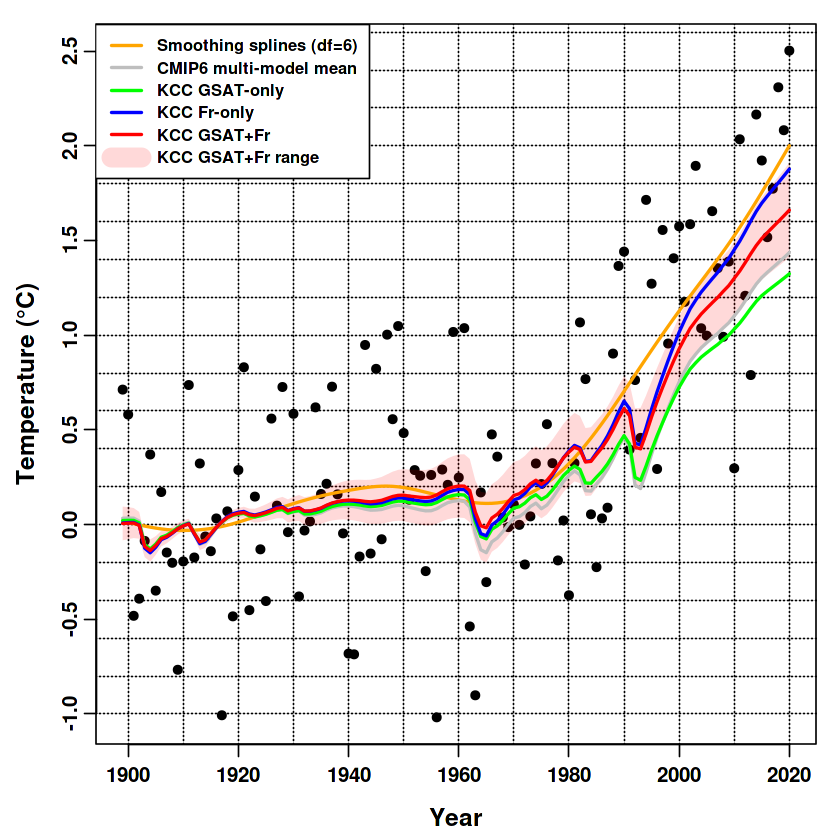

In [12]:
source("routines/plot_fig1.R")

**Figure 2**: Regional to global warming ratio


Attaching package: ‘ellipse’


The following object is masked from ‘package:graphics’:

    pairs




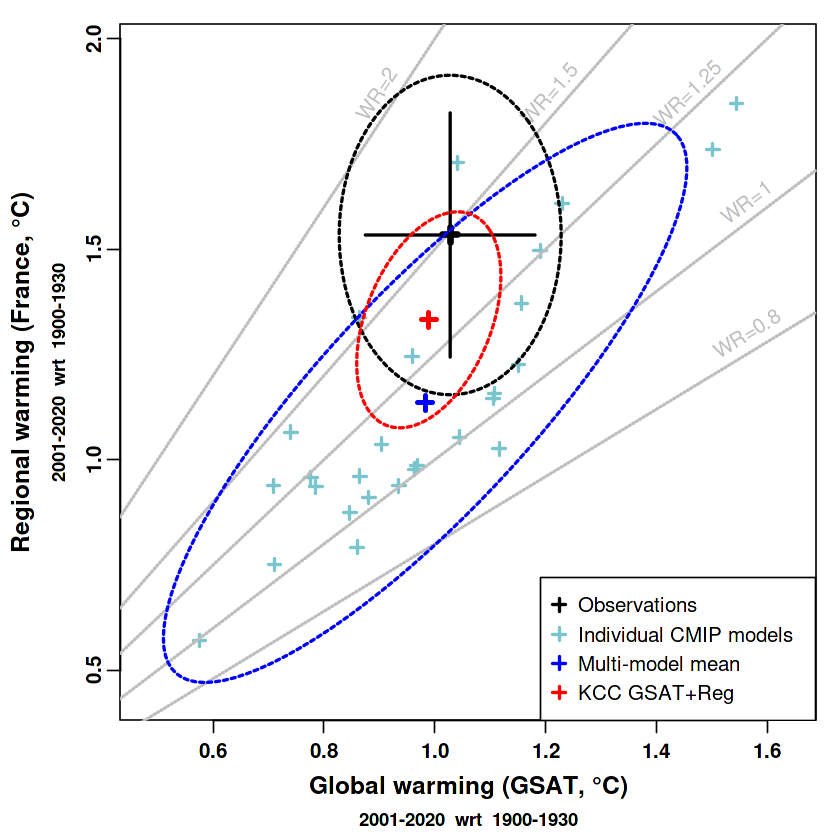

In [13]:
source("routines/plot_fig2.R")

**Figure 3a**: Attribution

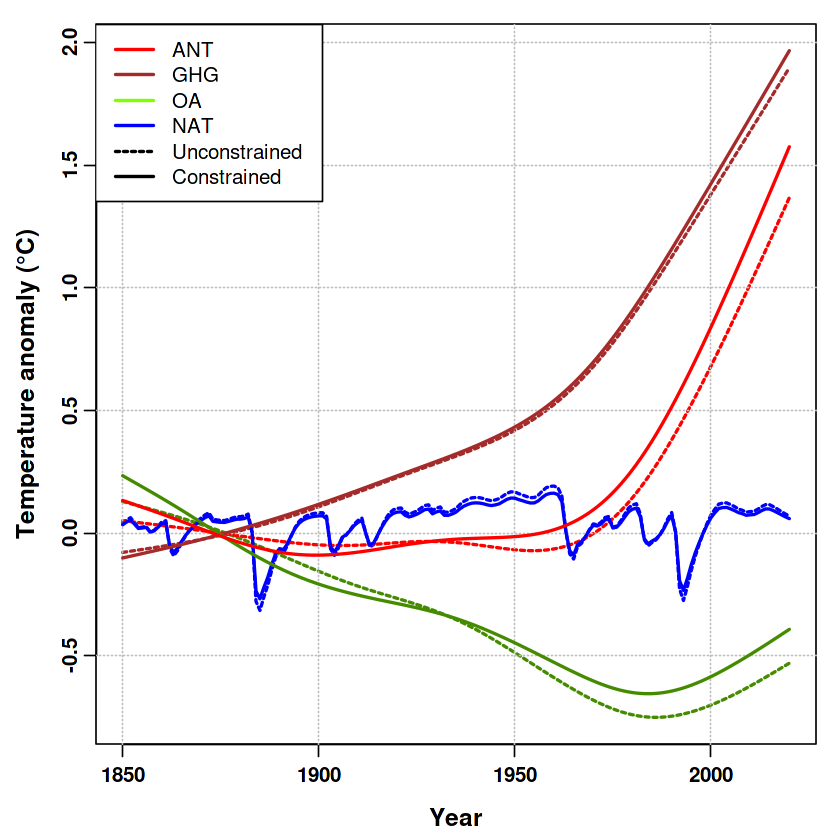

In [14]:
source("routines/plot_fig3a.R")

**Figure 5**: Constrained projections

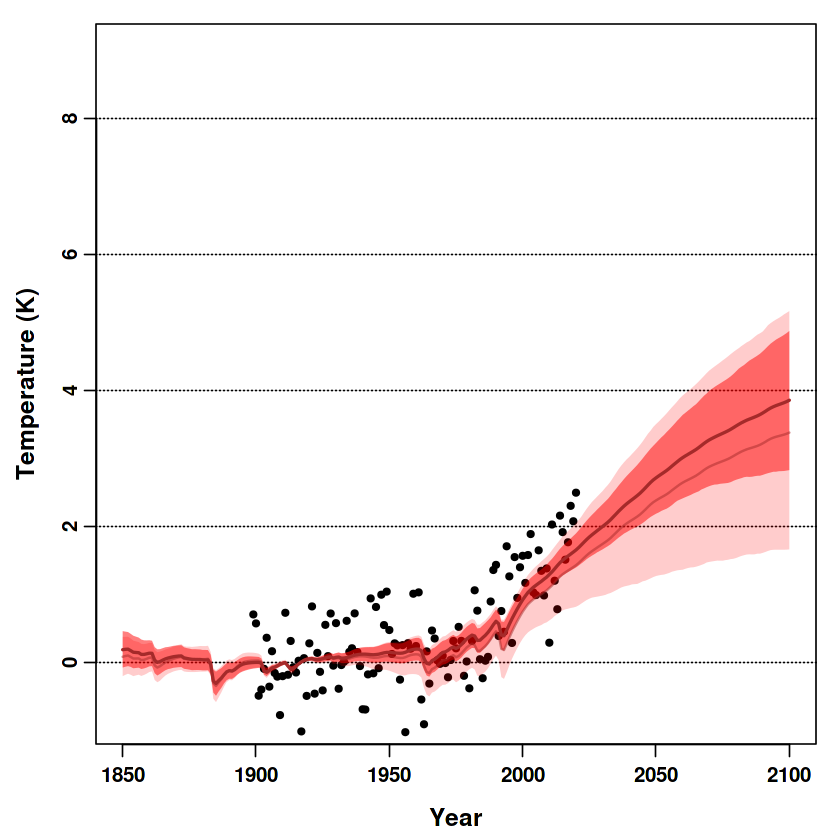

In [15]:
source("routines/plot_cons.R")
plot_cons(CX_full[,,"loc",,],Xof,ref_plot=1900:1930,ylim=c(-.8,9))